<a href="https://colab.research.google.com/github/21328739/Arduino/blob/main/Tezcal%C4%B1smas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Veriseti

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip
!unzip DIV2K_valid_LR_bicubic_X2.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
!unzip DIV2K_train_LR_bicubic_X2.zip

--2023-01-12 10:10:03--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip [following]
--2023-01-12 10:10:04--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117763600 (112M) [application/zip]
Saving to: ‘DIV2K_valid_LR_bicubic_X2.zip’

DIV2K_valid_LR_bicu 100%[===================>] 112.31M  15.2MB/s    in 8.6s    

2023-01-12 10:10:13 (13.1 MB/s) - ‘DIV2K_valid_LR_bicubic_X2.zip’ saved [117763600/117763600]

Archive:  DIV2K_valid_LR_bicubic_X2.zip
   creating: DIV2K_valid

In [ ]:
from torch.utils.data import Dataset
from glob import glob
import cv2
import numpy as np

# Dataset sınıfı verileri modele verir
# init başlangıçtaki verisetini gösterir

class MyDataset(Dataset):
    def __init__(self, train=True, noise_var=25, resize=None):
      # training ve test verileri
        if train:
            files = glob("DIV2K_train_LR_bicubic/X2/*.*")
        else:
            files = glob("DIV2K_valid_LR_bicubic/X2/*.*")
      # 25 gaussian gürültüsü kaydet.
        self.files = files
        self.noise_var = noise_var
        self.resize = resize

    def __getitem__(self, index):
      # oepncv ile imaj okuma
        image = cv2.imread(self.files[index])
        # imaj şekli oku
        row, col, ch = image.shape
        # numpy gürültüyü göstermek için kullanılır
        gauss = np.random.normal(0, self.noise_var, (row, col, ch))
        gauss = gauss.reshape((row, col, ch))
        # gürültü ekle
        noisy = image + gauss
        # 
        if self.resize is not None:
            image = cv2.resize(image, self.resize)
            noisy = cv2.resize(noisy, self.resize)
        # boy,en,kanal => kanal, boy, en (transpose)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)/255
        noisy = np.transpose(noisy, (2, 0, 1)).astype(np.float32)/255
        # veriyi döndür
        return {"image": image, "noisy": noisy}

    def __len__(self):
        return len(self.files)


Define network

In [ ]:
import torch.nn as nn

# conv + deconv kullanıldı
class Red(nn.Module):
  # out_ch sabit
    def __init__(self, out_ch=96):
        super(Red, self).__init__()
        # convolution, verinini ifade ettikleri (kanal , boy, en)
        self.conv1 = nn.Conv2d(3, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv4 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv5 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        #deconvolution
        self.tconv1 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv2 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv3 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv4 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv5 = nn.ConvTranspose2d(out_ch, 3, kernel_size=5, stride=1, padding=0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # encoder
        residual_1 = x
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        residual_2 = out
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        residual_3 = out
        out = self.relu(self.conv5(out))
        # decoder
        out = self.tconv1(out)
        out += residual_3
        out = self.tconv2(self.relu(out))
        out = self.tconv3(self.relu(out))
        out += residual_2
        out = self.tconv4(self.relu(out))
        out = self.tconv5(self.relu(out))
        out += residual_1
        out = self.relu(out)
        return out

# vgg discriminator
class VGGDiscriminator(nn.Module):

    def __init__(self, num_in_ch=3, num_feat=64, input_size=256):
        super(VGGDiscriminator, self).__init__()
        self.input_size = input_size

        self.conv0_0 = nn.Conv2d(num_in_ch, num_feat, 3, 1, 1, bias=True)
        self.conv0_1 = nn.Conv2d(num_feat, num_feat, 4, 2, 1, bias=False)
        self.bn0_1 = nn.BatchNorm2d(num_feat, affine=True)

        self.conv1_0 = nn.Conv2d(num_feat, num_feat * 2, 3, 1, 1, bias=False)
        self.bn1_0 = nn.BatchNorm2d(num_feat * 2, affine=True)
        self.conv1_1 = nn.Conv2d(num_feat * 2, num_feat * 2, 4, 2, 1, bias=False)
        self.bn1_1 = nn.BatchNorm2d(num_feat * 2, affine=True)

        self.conv2_0 = nn.Conv2d(num_feat * 2, num_feat * 4, 3, 1, 1, bias=False)
        self.bn2_0 = nn.BatchNorm2d(num_feat * 4, affine=True)
        self.conv2_1 = nn.Conv2d(num_feat * 4, num_feat * 4, 4, 2, 1, bias=False)
        self.bn2_1 = nn.BatchNorm2d(num_feat * 4, affine=True)

        self.conv3_0 = nn.Conv2d(num_feat * 4, num_feat * 8, 3, 1, 1, bias=False)
        self.bn3_0 = nn.BatchNorm2d(num_feat * 8, affine=True)
        self.conv3_1 = nn.Conv2d(num_feat * 8, num_feat * 8, 4, 2, 1, bias=False)
        self.bn3_1 = nn.BatchNorm2d(num_feat * 8, affine=True)

        self.conv4_0 = nn.Conv2d(num_feat * 8, num_feat * 8, 3, 1, 1, bias=False)
        self.bn4_0 = nn.BatchNorm2d(num_feat * 8, affine=True)
        self.conv4_1 = nn.Conv2d(num_feat * 8, num_feat * 8, 4, 2, 1, bias=False)
        self.bn4_1 = nn.BatchNorm2d(num_feat * 8, affine=True)

        self.conv5_0 = nn.Conv2d(num_feat * 8, num_feat * 8, 3, 1, 1, bias=False)
        self.bn5_0 = nn.BatchNorm2d(num_feat * 8, affine=True)
        self.conv5_1 = nn.Conv2d(num_feat * 8, num_feat * 8, 4, 2, 1, bias=False)
        self.bn5_1 = nn.BatchNorm2d(num_feat * 8, affine=True)
        t_size = input_size//64
        self.linear1 = nn.Linear(num_feat * 8 * t_size * t_size, 100)
        self.linear2 = nn.Linear(100, 1)

        # aktiv. fonk.
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        # self.sig = nn.Sigmoid()

    def forward(self, x):
        assert x.size(2) == self.input_size, (f'Input size must be identical to input_size, but received {x.size()}.')

        feat = self.lrelu(self.conv0_0(x))
        feat = self.lrelu(self.bn0_1(self.conv0_1(feat)))  # output boyut: /2

        feat = self.lrelu(self.bn1_0(self.conv1_0(feat)))
        feat = self.lrelu(self.bn1_1(self.conv1_1(feat)))  #  output boyut: /4

        feat = self.lrelu(self.bn2_0(self.conv2_0(feat)))
        feat = self.lrelu(self.bn2_1(self.conv2_1(feat)))  #  output boyut: /8

        feat = self.lrelu(self.bn3_0(self.conv3_0(feat)))
        feat = self.lrelu(self.bn3_1(self.conv3_1(feat)))  #  output boyut: /16

        feat = self.lrelu(self.bn4_0(self.conv4_0(feat)))
        feat = self.lrelu(self.bn4_1(self.conv4_1(feat)))  #  output boyut: /32

        feat = self.lrelu(self.bn5_0(self.conv5_0(feat)))
        feat = self.lrelu(self.bn5_1(self.conv5_1(feat)))  # output boyut: / 64

        # spatial size: (4, 4)
        feat = feat.view(feat.size(0), -1)
        feat = self.lrelu(self.linear1(feat))
        out = self.linear2(feat)
        # out = self.sig(out)
        return out


Train

g-54.855831146240234	d-49.10708999633789: 100%|██████████| 200/200 [04:57<00:00,  1.49s/it]


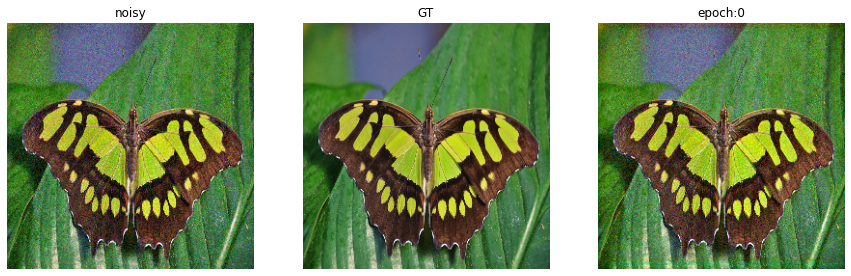

g-59.094329833984375	d-52.92337417602539:   6%|▌         | 11/200 [00:21<04:51,  1.54s/it] 

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2


def train():
  # veriyi yükle
    train_dataloader = DataLoader(MyDataset(train=True, resize=(256, 256), noise_var=25), batch_size=4, shuffle=True,
                                  num_workers=4)
    test_dataloader = DataLoader(MyDataset(train=False, resize=(256, 256), noise_var=25), batch_size=1, shuffle=True,
                                 num_workers=4)
    # gpu check
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # neural ağ
    generator = Red().to(device)
    discriminator = VGGDiscriminator(num_feat=32).to(device)
    # rmsprop optimizer önerildiği için kullanıldı
    optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=1e-4)
    optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=1e-4)
    #  loss function, Binary cross entropy and mean square error kullanıldı.
    crit = torch.nn.BCELoss().to(device)
    mse = torch.nn.MSELoss().to(device)

    for current_epoch in range(200):
        progress_bar = tqdm(train_dataloader)
        for cnt, batch_data in enumerate(progress_bar):
            x = batch_data['noisy'].to(device)
            y = batch_data['image'].to(device)
            optimizer_D.zero_grad()
            # önce disc eğitilir
            # imaj üret
            fake_imgs = generator(x).detach()
            # Adversarial loss
            loss_D = -torch.mean(discriminator(y)) + 0.1 * torch.mean(discriminator(fake_imgs))
            loss_D.backward()
            optimizer_D.step()
            
            for p in discriminator.parameters():
                p.data.clamp_(-0.1, 0.1)

            # 2 iterasyonda bir eğit
            if cnt % 2 == 0:
                # -----------------
                #  generator eğit
                # -----------------
                optimizer_G.zero_grad()
                # imaj üret
                gen_imgs = generator(x)
                # Adversarial loss
                loss_G = -torch.mean(discriminator(gen_imgs)) + mse(gen_imgs, y)
                loss_G.backward()
                optimizer_G.step()
                progress_bar.set_description("g{}\td{}".format(loss_G.item(), loss_D.item()))
        # 10 epochta bir test
        if current_epoch % 10 == 0:
            with torch.no_grad():
                for batch_data in test_dataloader:
                    x = batch_data['noisy'].to(device)
                    y = batch_data['image']
                    pred = generator(x)
                    # kanal boy en => boy,en,kanal
                    x = np.transpose(x[0].cpu().numpy(), (1, 2, 0))
                    y = np.transpose(y[0].cpu().numpy(), (1, 2, 0))
                    pred = np.transpose(pred[0].cpu().numpy(), (1, 2, 0))
                    fig = plt.figure(figsize=(15, 6))
                    # 131, 132, 133,1 satır 3 sütun
                    ax1 = fig.add_subplot(131)
                    ax1.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
                    ax1.axis('off')
                    ax1.title.set_text("noisy")
                    ax2 = fig.add_subplot(132)
                    ax2.imshow(cv2.cvtColor(y, cv2.COLOR_BGR2RGB))
                    ax2.axis('off')
                    ax2.title.set_text("GT")
                    ax3 = fig.add_subplot(133)
                    ax3.imshow(cv2.cvtColor(pred, cv2.COLOR_BGR2RGB))
                    ax3.axis('off')
                    ax3.title.set_text("Output")
                    plt.title("epoch:{}".format(current_epoch))
                    plt.savefig("./{}.png".format(current_epoch))
                    plt.show()
                    plt.close(fig)
                    1 resim göster
                    break
            # test için kaydet
            torch.save({"generator": generator.state_dict(),
                        "discriminator": discriminator.state_dict()}, "./model.pth")


if __name__ == '__main__':
    train()


Test

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

if __name__ == '__main__':
  
    test_dataloader = DataLoader(MyDataset(train=False, resize=(256, 256), noise_var=25), batch_size=1, shuffle=True,
                                 num_workers=2)
    # modeli tanımla
    device = "cuda" if torch.cuda.is_available() else "cpu"
    generator = Red().to(device)
    model = torch.load("./model.pth", map_location=torch.device(device))
    generator.load_state_dict(model['generator'])
    # gradient testte kullanılmaz
    with torch.no_grad():
      # 3 sonuc
        psnr_list = []
        ssim_list = []
        mse_list = []
        
        for cnt, batch_data in enumerate(test_dataloader):
            x = batch_data['noisy'].to(device)
            y = batch_data['image']
            pred = generator(x)
            x = np.transpose(x[0].cpu().numpy(), (1, 2, 0)).clip(0, 1)
            y = np.transpose(y[0].cpu().numpy(), (1, 2, 0)).clip(0, 1)
            pred = np.transpose(pred[0].cpu().numpy(), (1, 2, 0)).clip(0, 1)
            psnr_list.append(peak_signal_noise_ratio(y, pred, data_range=1))
            ssim_list.append(structural_similarity(y, pred, channel_axis=2, multichannel=True))
            mse_list.append(mean_squared_error(y, pred))
            fig = plt.figure(figsize=(15, 6))
            ax1 = fig.add_subplot(131)
            ax1.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
            ax1.axis('off')
            ax1.title.set_text("noisy")
            ax2 = fig.add_subplot(132)
            ax2.imshow(cv2.cvtColor(y, cv2.COLOR_BGR2RGB))
            ax2.axis('off')
            ax2.title.set_text("GT")
            ax3 = fig.add_subplot(133)
            ax3.imshow(cv2.cvtColor(pred, cv2.COLOR_BGR2RGB))
            ax3.axis('off')
            ax3.title.set_text("Output")
            
            plt.show()
            plt.close(fig)
        # ekrana yazdır
        print("psnr:{}".format(np.average(psnr_list)))
        print("ssim:{}".format(np.average(ssim_list)))
        print("mse:{}".format(np.average(mse_list)))

